In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import sqlite3

In [28]:
# This creates a TS, where the distribution changes at different points deppending on a provided list of distribution shifts.
def Create_TimeSeries(s, dist_shifts):
    n = s//len(dist_shifts)
    m = s%len(dist_shifts)

    final = np.array([])
    
    for i in range(len(dist_shifts)-1):
        Y = abs(np.random.normal(dist_shifts[i][0], dist_shifts[i][1], n))
        final = np.concatenate((final, Y))
    
    final = np.concatenate((final, abs(np.random.normal(dist_shifts[-1][0], dist_shifts[-1][1], n+m)))) 
    
    return final + 0.5*np.roll(final, 1)

# Generating the data.

In [29]:

p = 0.5
pdist, steps = [1-p, p], [-1, 1]

datapoints = 20
seq_length = 300

train_Output = []

# These are the distribution shifts that will be applied to the time series
dist_shift = [(0, 1), (0, 10), (-10, 1)]
#dist_shift = [(0,1), (2,0)]
#dist_shift = [((-1**x) * 100, 100) if x%5==0 else (0, 0) for x in range(30)]

for _ in range(datapoints):
    X =  np.random.choice(steps, size=seq_length, p=pdist)
    Y = Create_TimeSeries(seq_length, dist_shift)
    T = np.cumsum(X*Y)
    
    input_data = T[:-1]
    labels_data = T[1:]

    train_Output.append((input_data, labels_data))


# DT_ACI vs ACI

In [37]:
inital_window_size = 50
alpha = 0.3
orignal_alpha = alpha 

# This function predicts a range of Y_t at the alpha level. By using alpha_t.
def C_t(alpha_t, scores, sigma_t, t):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-50:t], 1 - alpha_t)
    positve_v = (sigma_t) + (abs(sigma_t) * Q)
    negative_v = (sigma_t) - (abs(sigma_t) * Q)
    return negative_v, positve_v

# This function returns 1 if the prediction lies in the interval, 0 otherwise.
def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1
    
def l(B, theta, orignal_alpha):
    return (orignal_alpha * (B - theta)) - min(0, (B - theta))
l_vec = np.vectorize(l)

def M_t(alpha, scores, t):
    for B in np.linspace(0, 1, 1000):
        Q = np.quantile(scores[t-50:t], 1 - B)
        if np.mean(scores[t-49:t+1] >= Q) <= alpha:
            return B


def plots(error_list, coverage, range_list, alpha_list, B_t_list): 
    _, axs = plt.subplots(2, 2, figsize=(30, 10))

    axs[0][0].plot(1 - pd.Series(error_list).rolling(50).mean())
    axs[0][0].axhline(coverage, color='r', linestyle='--')
    axs[0][0].set_title('Coverage')
    
    axs[0][1].plot([ele[0] for ele in range_list], label='Lower')
    axs[0][1].plot([ele[1] for ele in range_list], label='Upper')
    axs[0][1].plot(y[51:])
    axs[0][1].set_title('Prediction')
    axs[0][1].legend()

    axs[1][0].plot([ele[1]-ele[0] for ele in range_list], label='Distance')
    axs[1][0].axhline(np.mean([ele[1]-ele[0] for ele in range_list]), color='r', linestyle='--')
    axs[1][0].legend()
    axs[1][0].set_title('Distance between upper and lower bounds')

    axs[1][1].plot(alpha_list,label='our alpha')
    axs[1][1].plot(B_t_list, label='alpha*')
    axs[1][1].legend()
    axs[1][1].set_title('Alpha')

    plt.show()

    return None

In [48]:
class Test:
    def addi(self, a, b):
        return a + b
    
    add_vec = np.vectorize(addi)

    def vec(self, a, b):
        return self.add_vec(a, b)
    
a = Test()
print(a.vec([1,2,3], [4,5,6]))

TypeError: addi() missing 1 required positional argument: 'b'

In [39]:
def ACI(alpha, input_gamma, train_Output, plots=False):
    alpha = alpha
    orignal_alpha = alpha 
    gamma = input_gamma

    total_coverage_list = []

    for m, (xpred, y) in enumerate(train_Output):
        # Getting the prediction and the actual value.
        
        # Calculating the scores at each time step
        All_scores = (abs(y - xpred))/abs(xpred)

        error_list = []
        range_list = []
        alpha_list = []
        alpha_star_list = []
        
        for i in range(51, len(All_scores)):
            # This is inclusive of i
            Coverage_t = C_t(alpha, All_scores, xpred[i], i)
            range_list.append(Coverage_t)

            error_t = err_t(y[i], Coverage_t)
            error_list.append(error_t)

            alpha = min(max(alpha + (gamma * (orignal_alpha - error_t)), 0), 1)
            alpha_list.append(alpha)

            alpha_star = M_t(0.3, All_scores, i)
            alpha_star_list.append(alpha_star)

        coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
        total_coverage_list.append(coverage)
        
        if m<10 and plots:
            plots(error_list, coverage, range_list, alpha_list, alpha_star_list)
            
        yield error_list, range_list, alpha_list, alpha_star_list 
    
    #return np.mean(total_coverage_list), Coverage_list

In [40]:
def Dt_ACI(alpha, train_Output, plots=False):
    total_coverage_list = []
    # The hyperparameters for the DtACI model.
    orignal_alpha = alpha
    sigma = 0.01
    #nu = np.sqrt((3/seq_length) * (np.log()))


    for m, (xpred, y) in enumerate(train_Output):
        # Initialising the gamma candidates and the weights.
        candiate_gamma = np.array([0.001, 0.002, 0.032, 0.128, 0.05, 0.1, 0.15, 0.25, 0.3, 0.4, 0.5])
        candiate_alpha = np.array([[orignal_alpha for _ in candiate_gamma]])
        gamma_weights = np.array([1 for _ in candiate_gamma])
        chosen_index = []
        
        error_list = []
        range_list = []
        alpha_list = []
        alpha_error_list = []
        B_t_list = []
        
        # Calculating the scores at each time step
        All_scores = (abs(y - xpred))/abs(xpred)

        #nu = np.sqrt((3/50) * (np.log(50*i) + 2/((1-alpha)**2 * alpha**2)))
        for i in range(51, len(All_scores)):
            nu = np.sqrt(3/50 * (np.log(10*50) + 2)/((1-alpha)**2 * alpha**2))
            
            # The probability of each gamma from the weights from step t.
            Wt = gamma_weights.sum()
            gamma_probabilites = gamma_weights/Wt
            
            # Choosing a alpha from the probabilites from the gamma candidates. Then calculating the coverage.
            chosen_alpha_t = np.random.choice(candiate_alpha[-1], p=gamma_probabilites)
            candiate_alpha_index = np.where(candiate_alpha[-1] == chosen_alpha_t)[0][0]
            chosen_index.append(candiate_alpha_index)

            #chosen_alpha_t = sum(gamma_probabilites * candiate_alpha[-1])
            alpha_list.append(chosen_alpha_t)
            
            Coverage_t = C_t(chosen_alpha_t, All_scores, xpred[i], i)
            
            
            range_list.append(Coverage_t)
            err_true = err_t(y[i], Coverage_t)
            error_list.append(err_true)

            # TIME FRONTIER -------

            # B is the sig level, we want the smallest one so that y is just in it.
            for possi in abs(np.linspace(-1, 0, 1000)):
                Cpossi= C_t(possi, All_scores, xpred[i], i)
                if Cpossi[0] < y[i] < Cpossi[1]:
                    B_t = possi
                    break
            
            B_t_list.append(B_t)
            
            
            # Updating the weights.
            new_weights = gamma_weights * np.exp(-nu * l_vec(B_t, candiate_alpha[-1], orignal_alpha))
            sumW, lenW = sum(new_weights), len(new_weights)
            final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
            gamma_weights = final_weights

            # Calculating the coverage and error at each time step, for different alpha values.
            alphai_errors = np.array([err_t(y[i], C_t(alpha_i, All_scores, xpred[i], i)) for alpha_i in candiate_alpha[-1]])
            alpha_error_list.append(alphai_errors)


            # Updating the alpha values.
            new_alphas = candiate_alpha[-1] + (candiate_gamma * (orignal_alpha - alphai_errors))
            candiate_alpha = np.vstack((candiate_alpha, new_alphas))

        coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
        total_coverage_list.append(coverage)
        
        if m<5 and plots:
            plots(error_list, coverage, range_list, alpha_list, B_t_list)

        yield error_list, range_list, alpha_list, chosen_index
        
    #return np.mean(total_coverage_list), range_list

In [41]:
print(6/2*3)

9.0


Got ACI
Got DtACI
ACI Coverage: 0.7037185929648241, DtACI Coverage: 0.6969849246231156
ACI variance: 0.003361046438221259, DtACI variance: 0.0018039746471048715


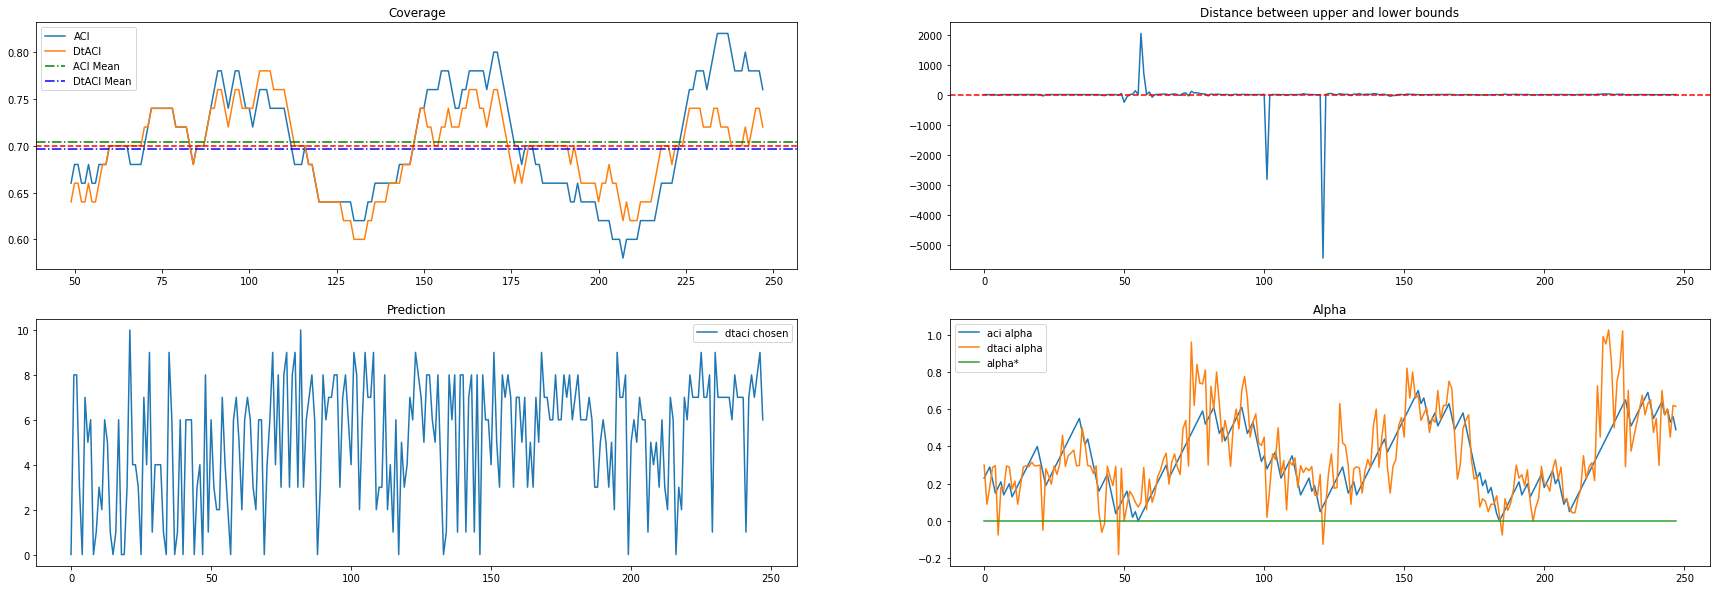

Got ACI
Got DtACI
ACI Coverage: 0.7142713567839196, DtACI Coverage: 0.7184924623115578
ACI variance: 0.007574717810156312, DtACI variance: 0.004675376884422112


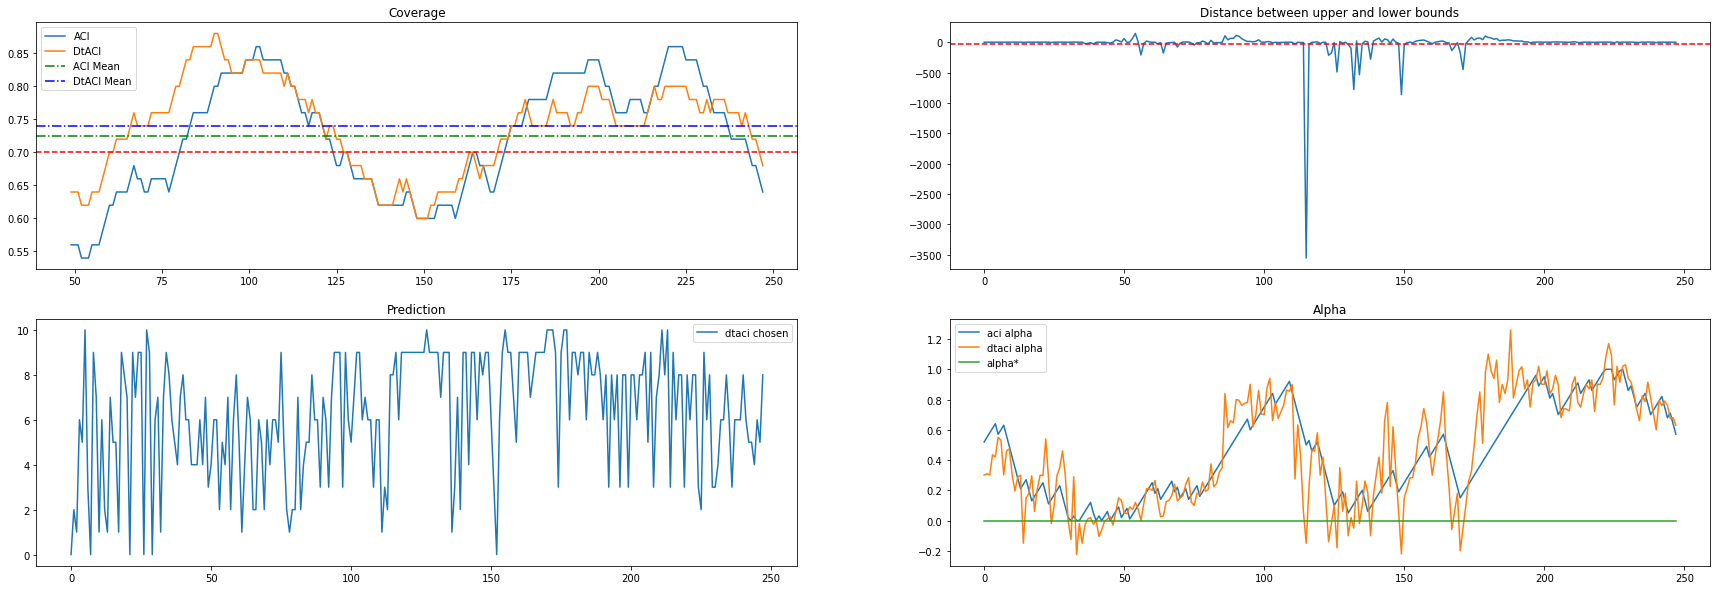

Got ACI
Got DtACI
ACI Coverage: 0.6991959798994974, DtACI Coverage: 0.7068341708542714
ACI variance: 0.007825721572687558, DtACI variance: 0.00365194818312669


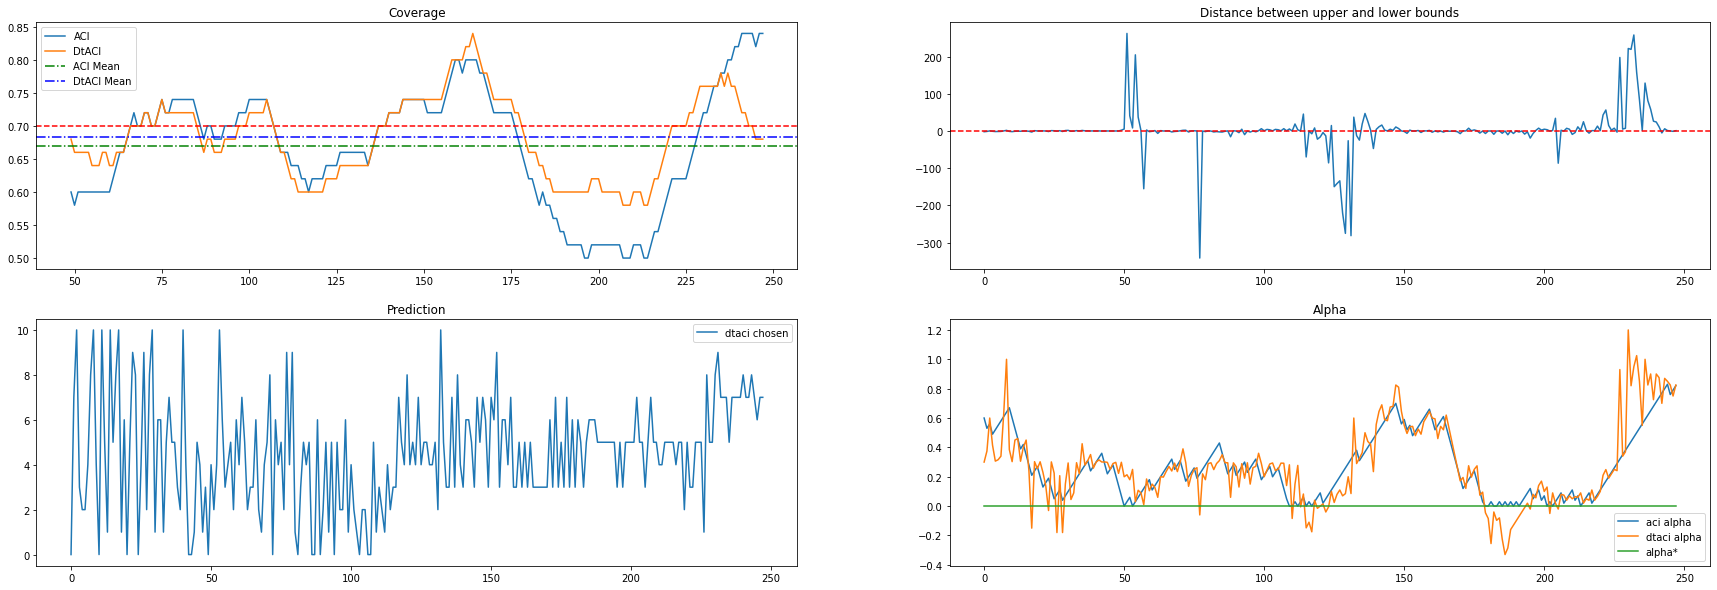

Got ACI
Got DtACI
ACI Coverage: 0.6924874371859295, DtACI Coverage: 0.7017336683417086
ACI variance: 0.00696879371733037, DtACI variance: 0.0043324966541248965


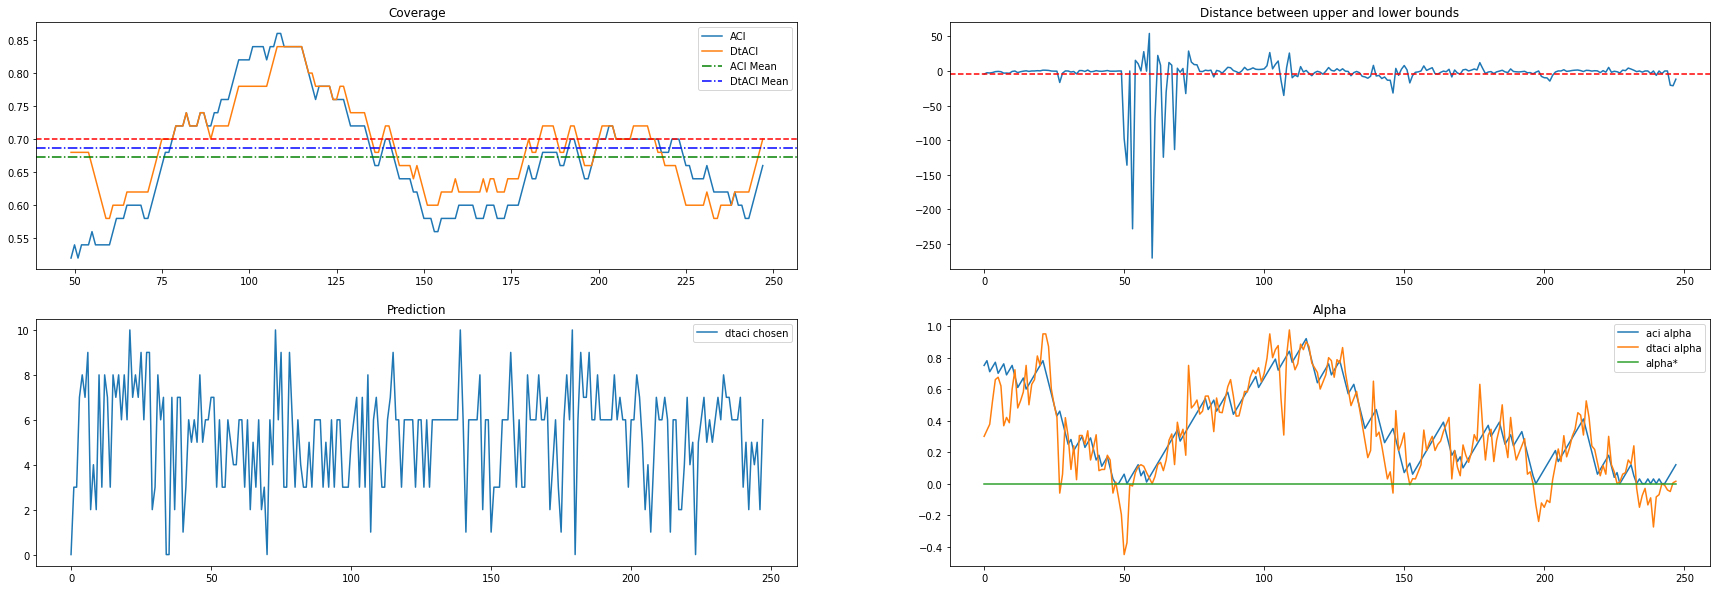

Got ACI
Got DtACI
ACI Coverage: 0.6946934673366834, DtACI Coverage: 0.7002814070351759
ACI variance: 0.004709234615287494, DtACI variance: 0.0016960783818590448


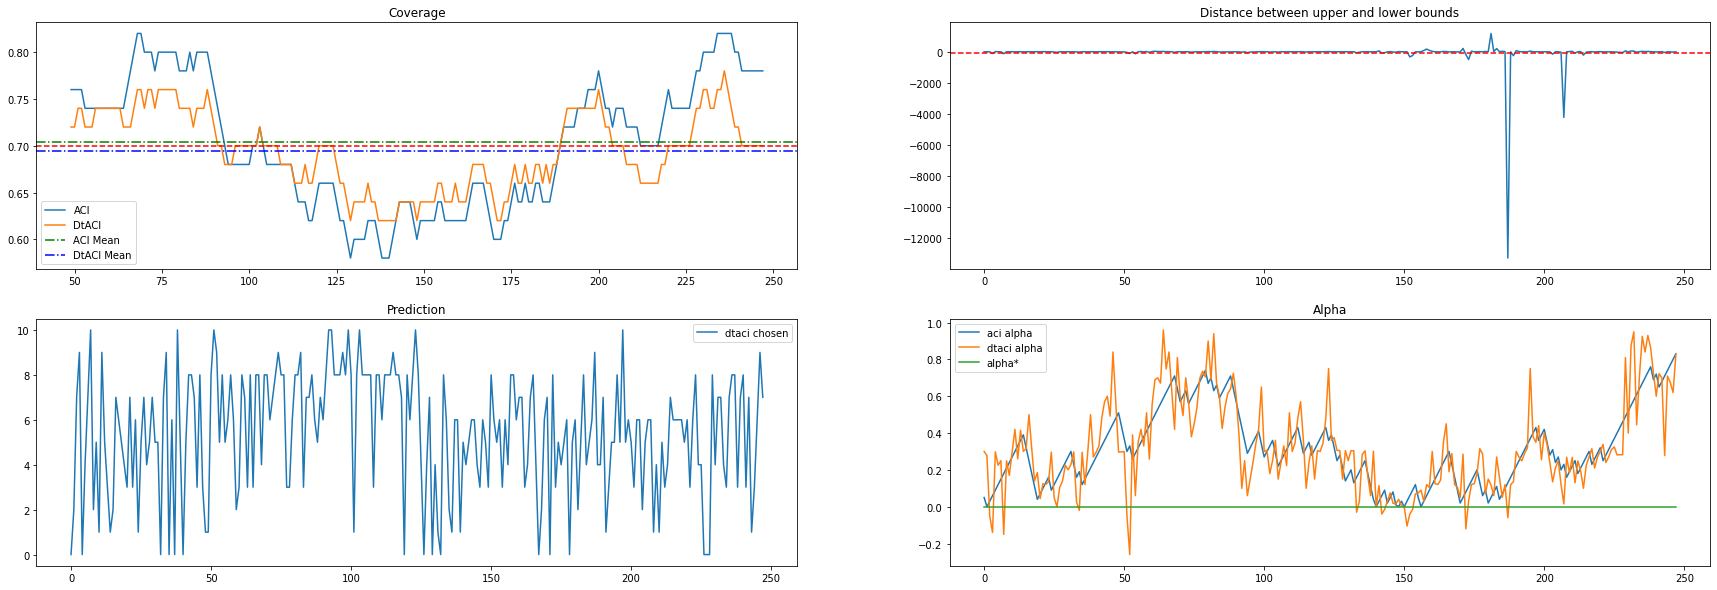

Got ACI
Got DtACI
ACI Coverage: 0.6981407035175878, DtACI Coverage: 0.6996984924623115
ACI variance: 0.005498224792303228, DtACI variance: 0.001452973409762381


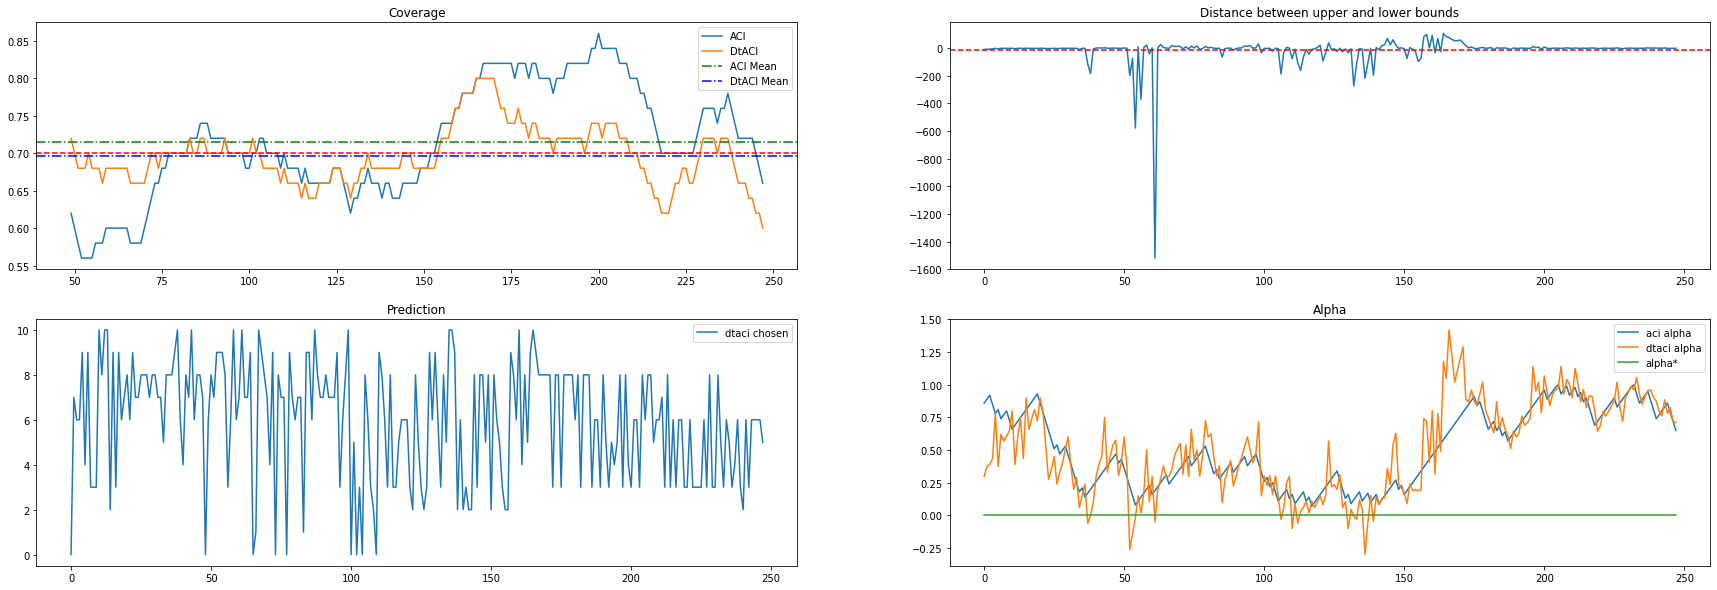

Got ACI
Got DtACI
ACI Coverage: 0.6981335247666905, DtACI Coverage: 0.7000287150035893
ACI variance: 0.008991328501805508, DtACI variance: 0.002560783818590441


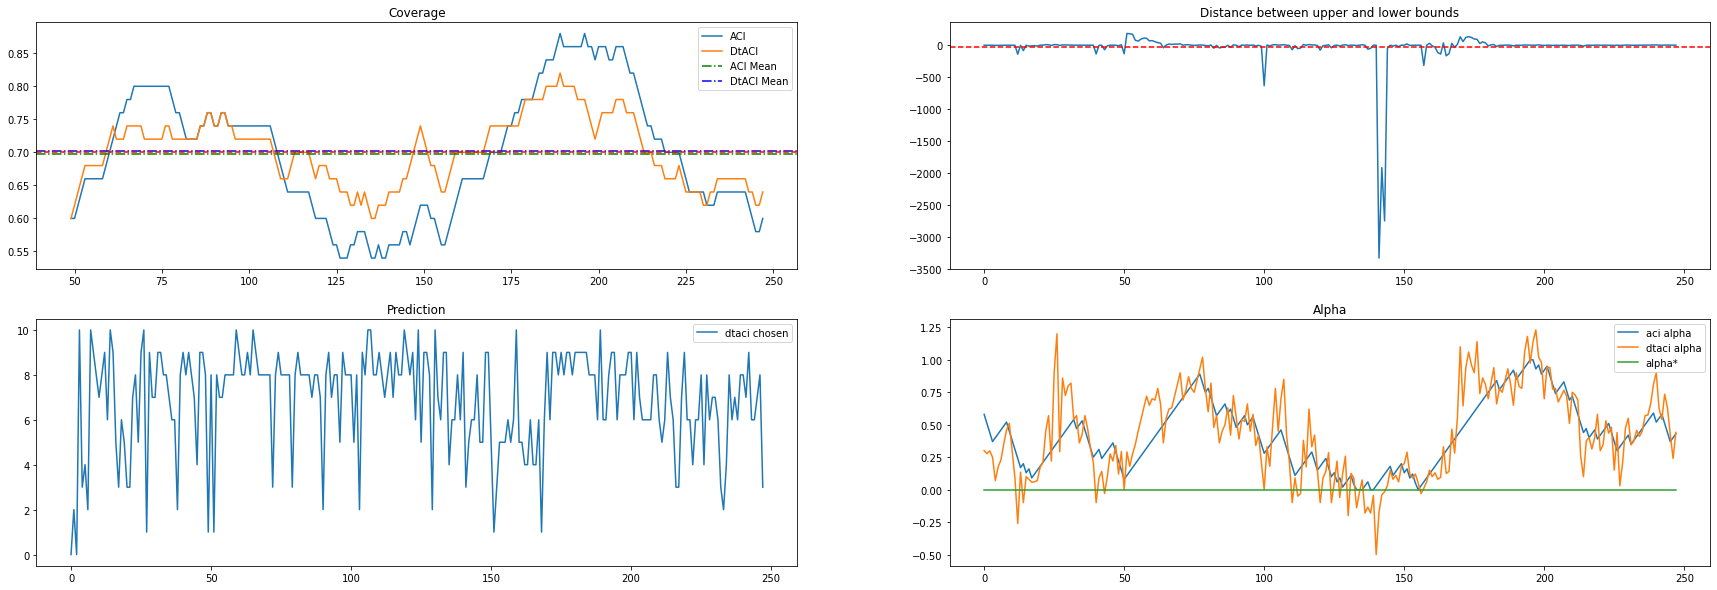

Got ACI
Got DtACI
ACI Coverage: 0.6982035175879397, DtACI Coverage: 0.6959045226130653
ACI variance: 0.0020786949824499403, DtACI variance: 0.0018399535365268543


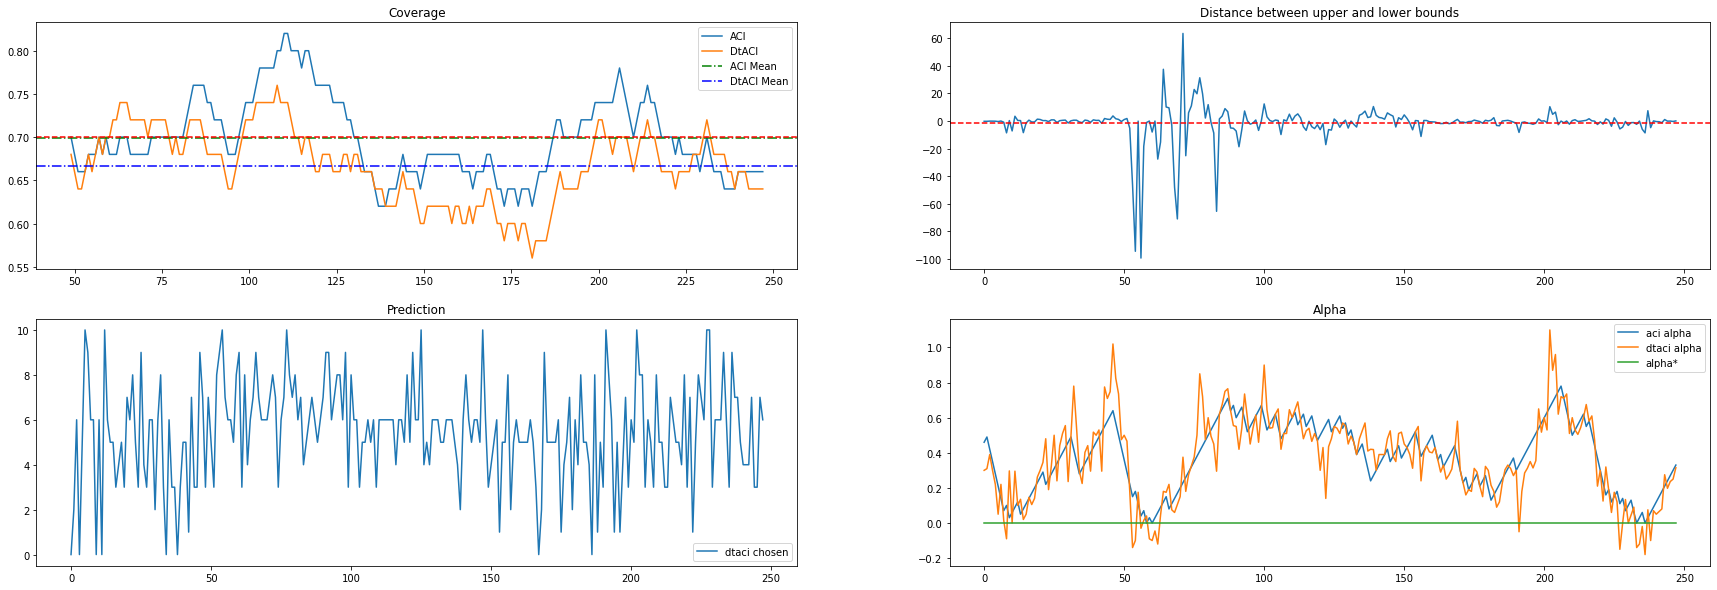

Got ACI
Got DtACI
ACI Coverage: 0.6987604690117253, DtACI Coverage: 0.6953322166387493
ACI variance: 0.002771566374586502, DtACI variance: 0.0013657634908209398


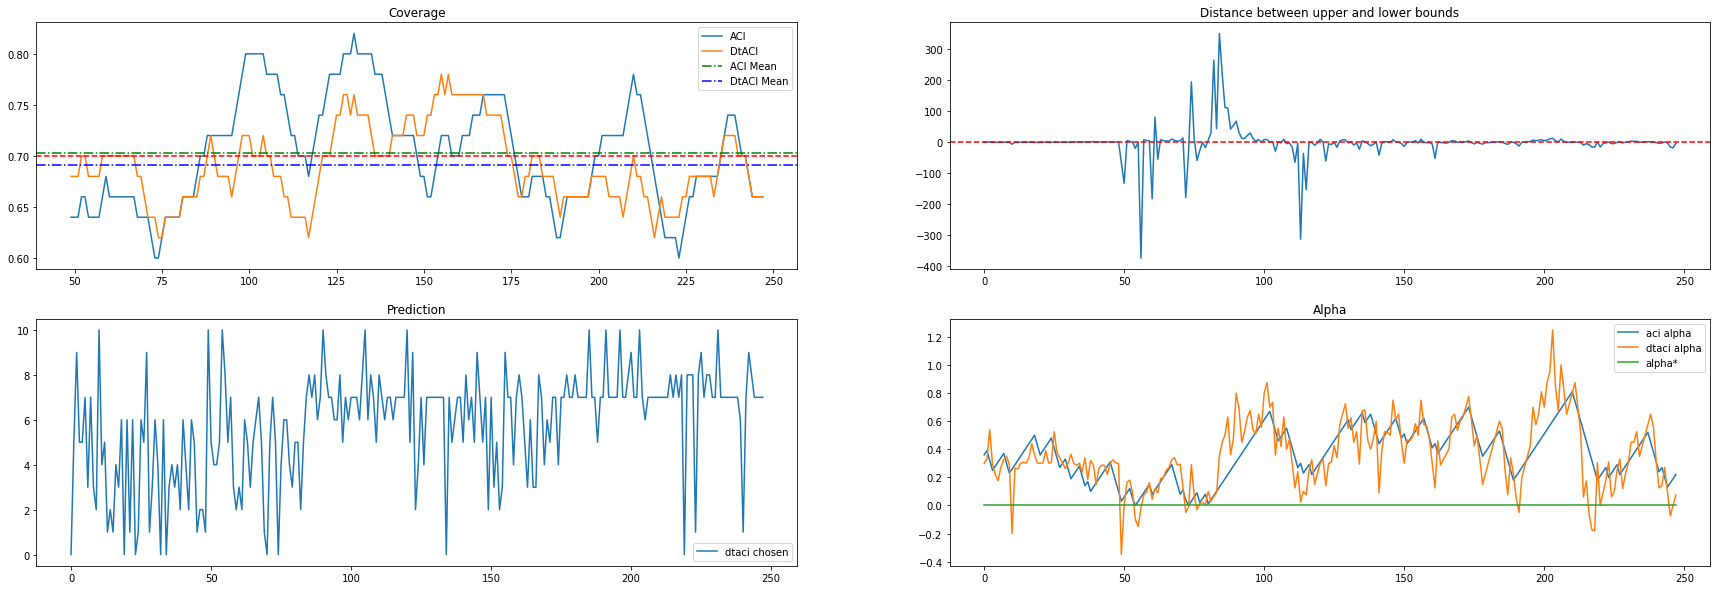

Got ACI
Got DtACI
ACI Coverage: 0.6996683417085428, DtACI Coverage: 0.6960603015075377
ACI variance: 0.003946587207393755, DtACI variance: 0.002099704552915331


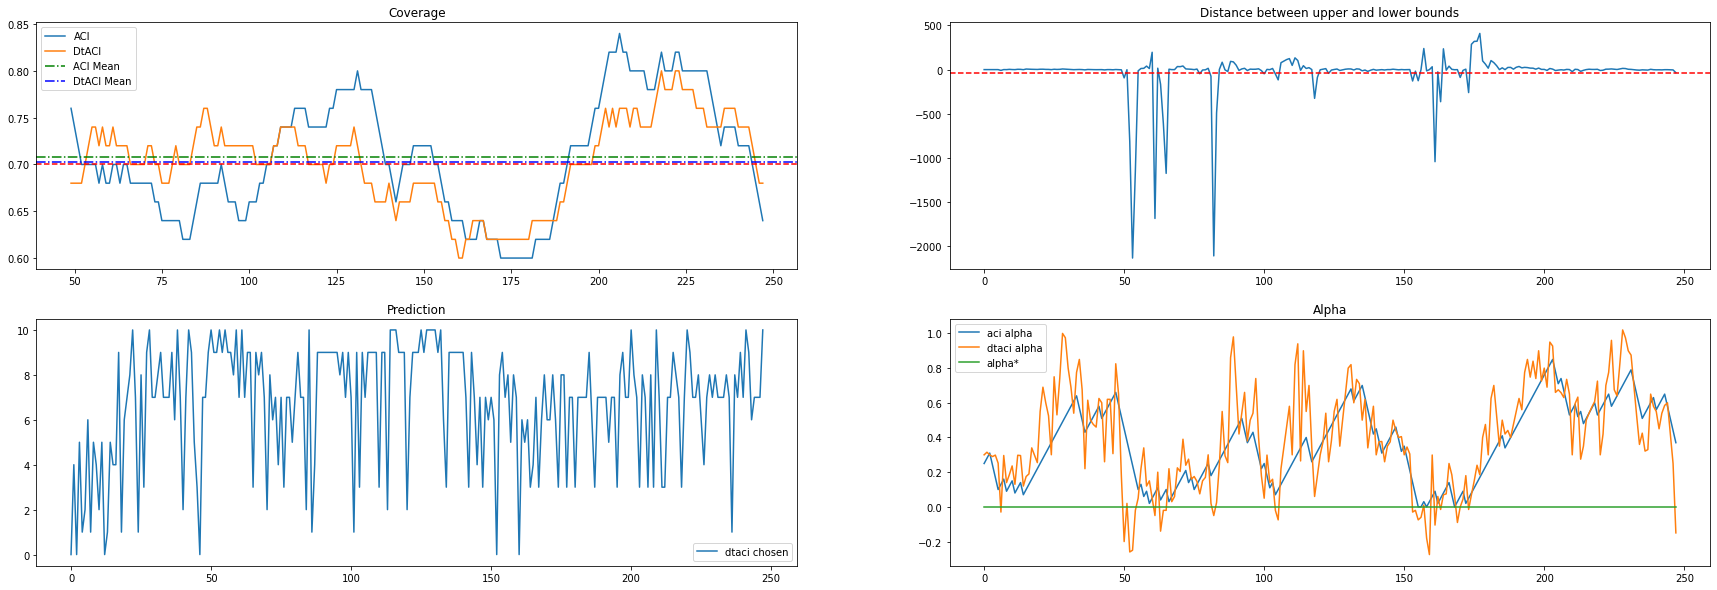

Got ACI
Got DtACI
ACI Coverage: 0.6991228871630882, DtACI Coverage: 0.6974326176336226
ACI variance: 0.006281518143481225, DtACI variance: 0.0015217797530365411


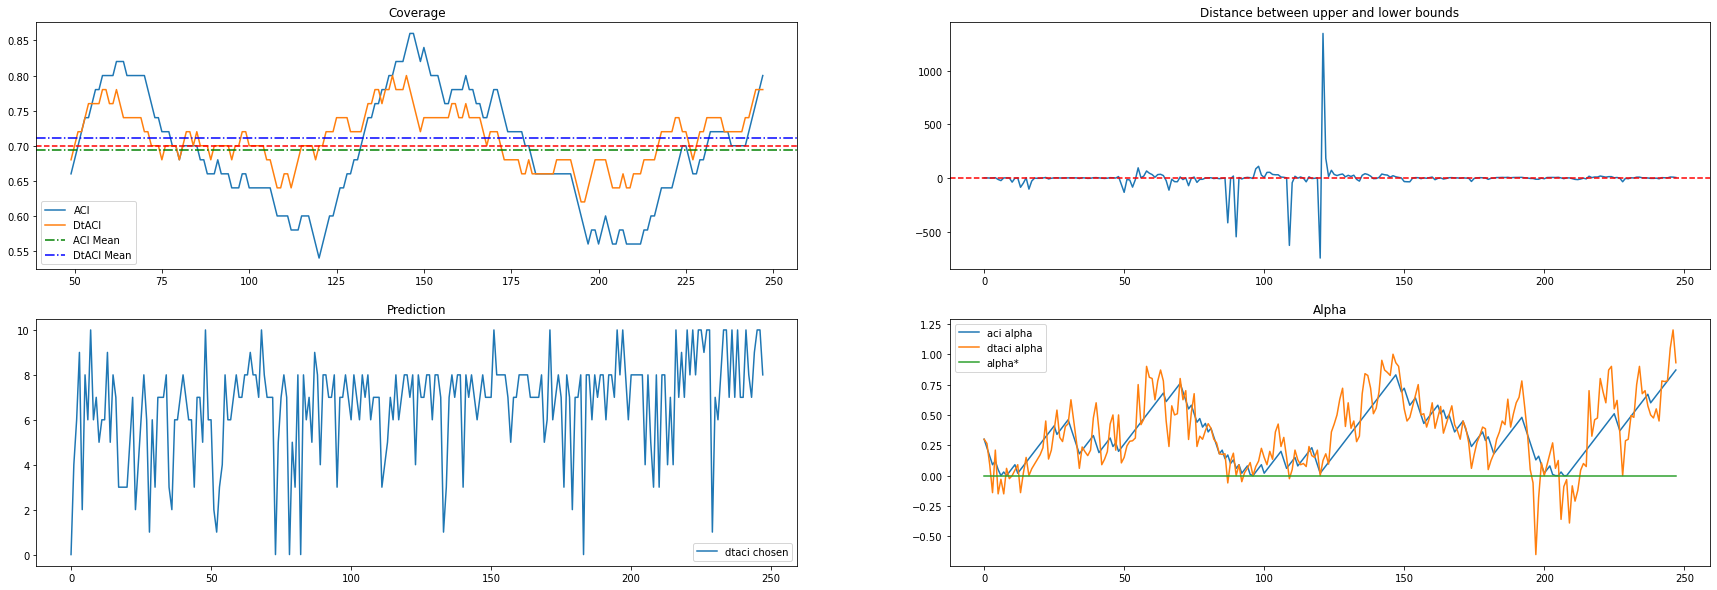

Got ACI
Got DtACI
ACI Coverage: 0.69892797319933, DtACI Coverage: 0.696323283082077
ACI variance: 0.00720975732936037, DtACI variance: 0.0023086487714956703


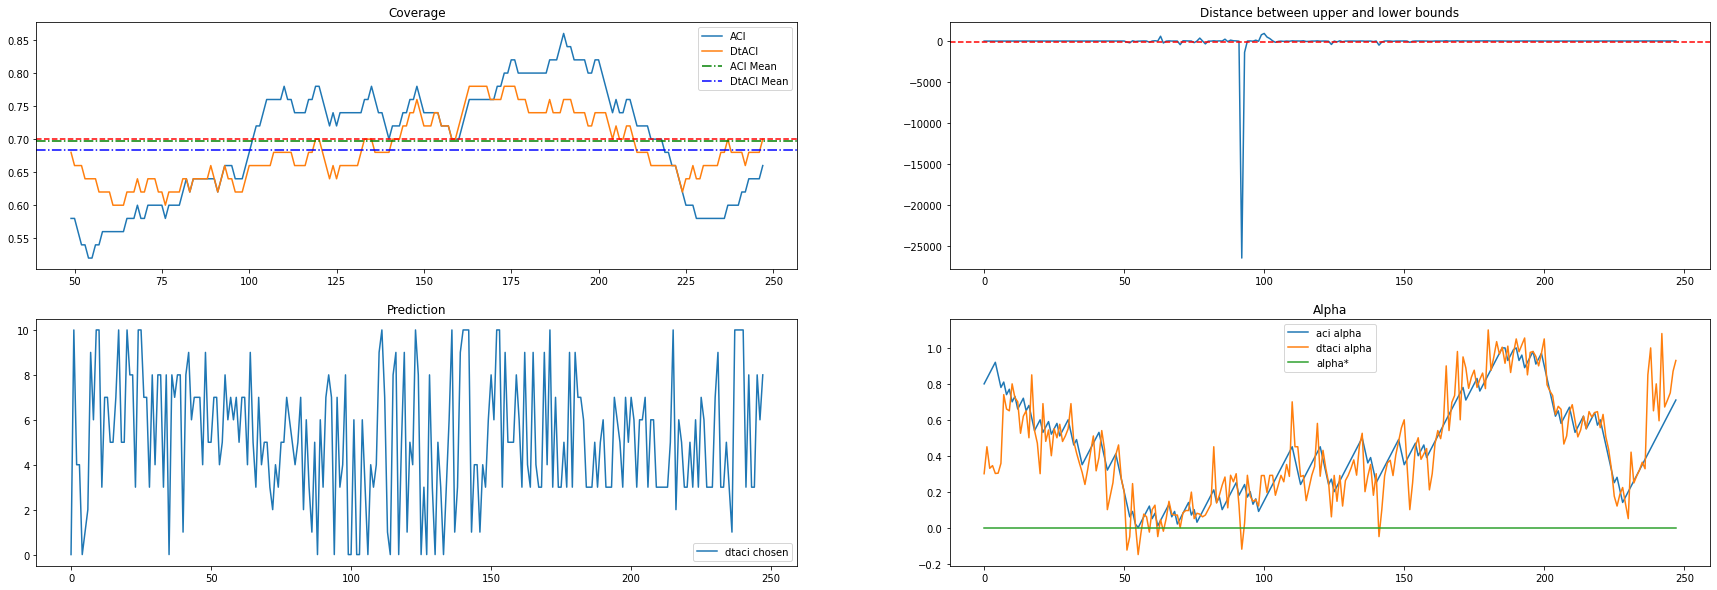

Got ACI
Got DtACI
ACI Coverage: 0.6992269037495168, DtACI Coverage: 0.6970699652106688
ACI variance: 0.003915699098507614, DtACI variance: 0.0022309739653039074


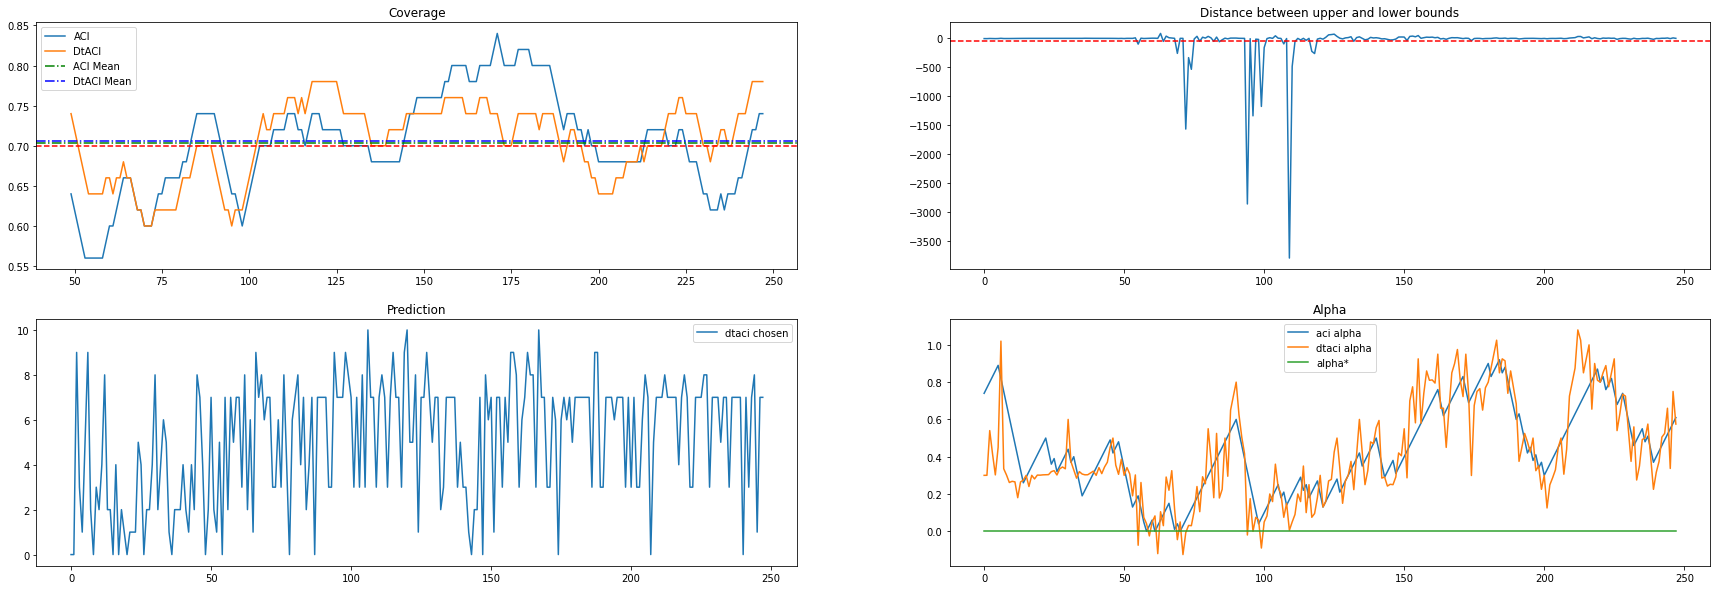

Got ACI
Got DtACI
ACI Coverage: 0.7012275664034459, DtACI Coverage: 0.6970208183776023
ACI variance: 0.00305919547486175, DtACI variance: 0.0017276129390671967


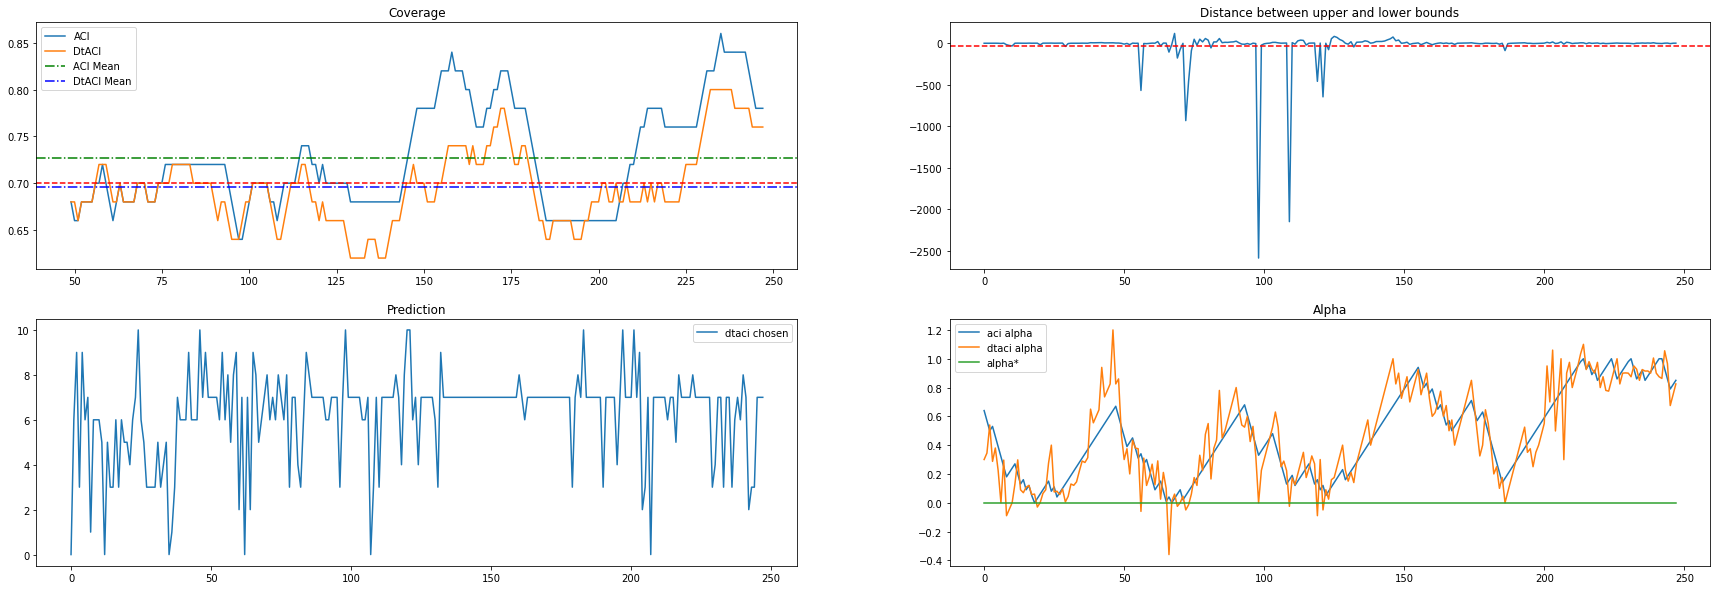

Got ACI
Got DtACI
ACI Coverage: 0.7012596314907873, DtACI Coverage: 0.6985192629815746
ACI variance: 0.002712658771243151, DtACI variance: 0.0016660791394156732


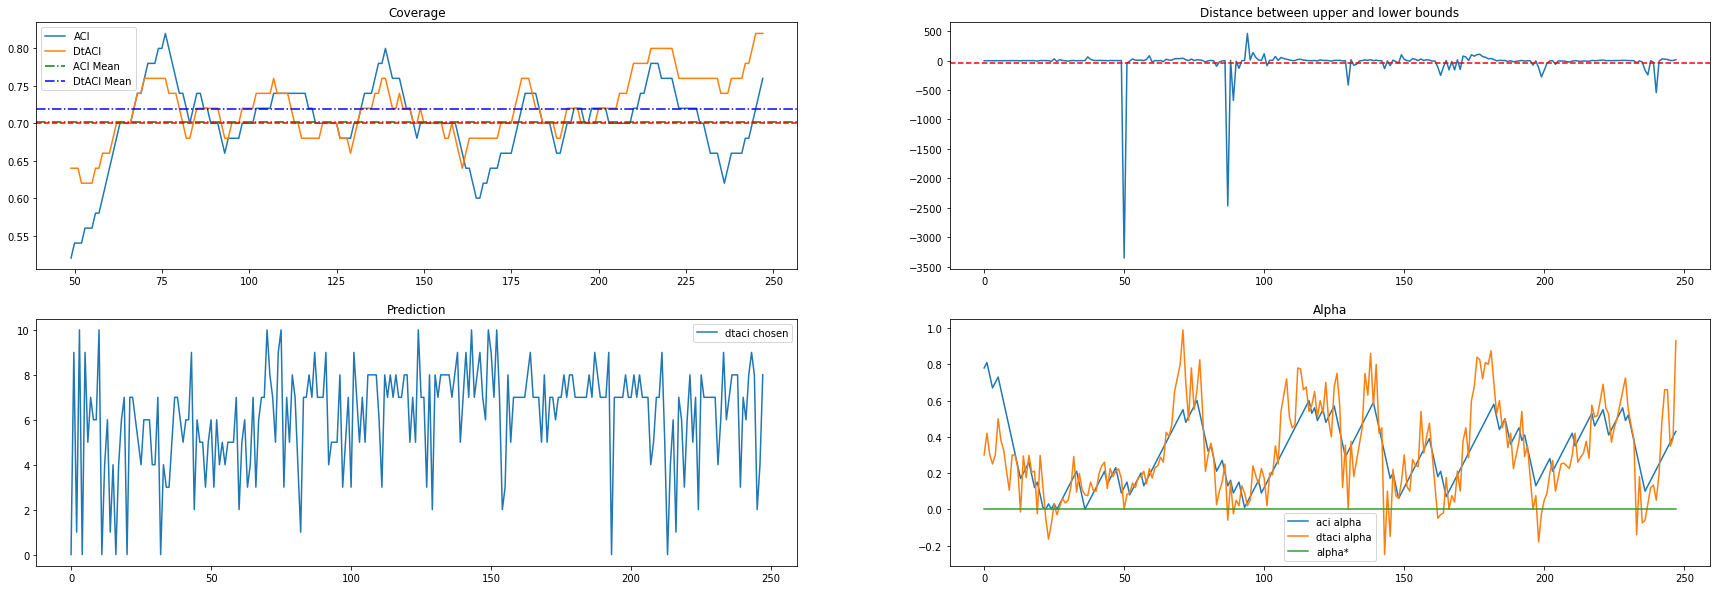

Got ACI
Got DtACI
ACI Coverage: 0.6996984924623115, DtACI Coverage: 0.6979585427135678
ACI variance: 0.006327880609075526, DtACI variance: 0.0021701472185045837


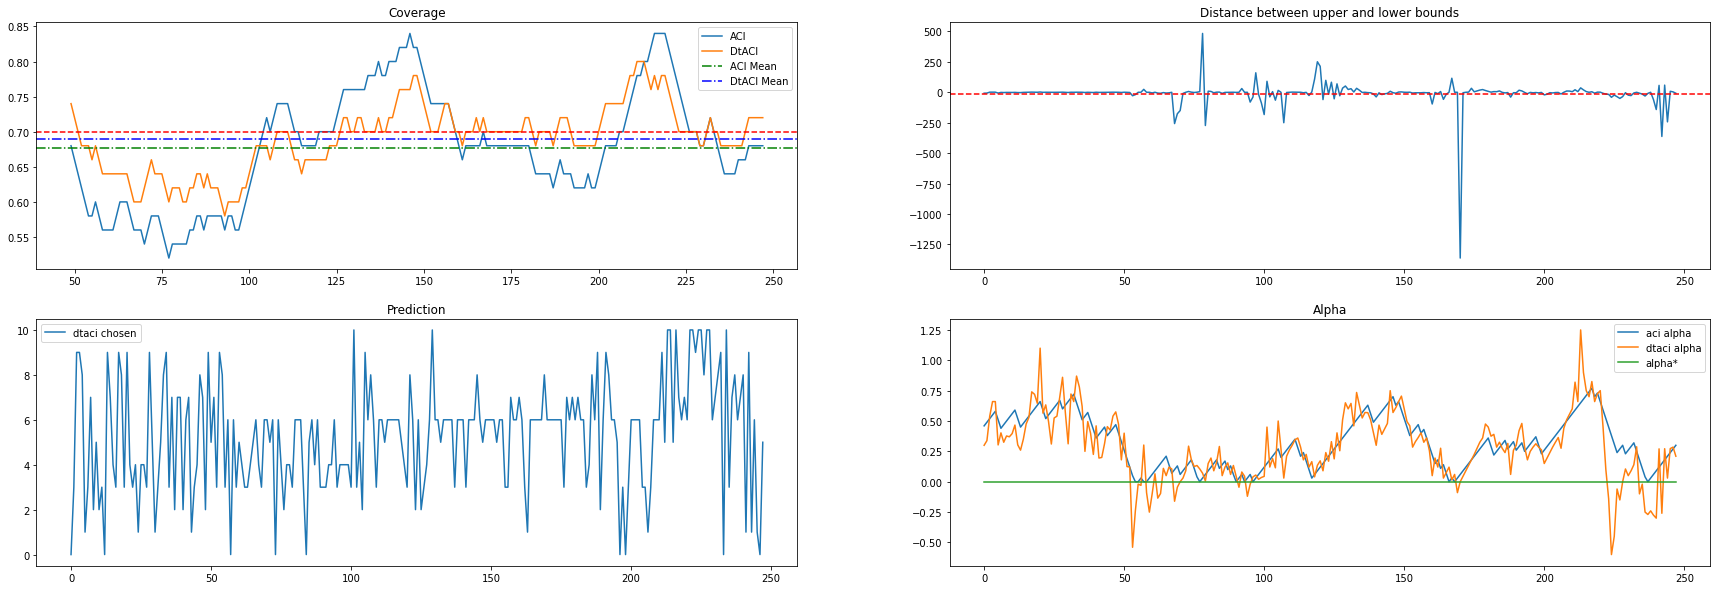

Got ACI
Got DtACI
ACI Coverage: 0.7004611291752881, DtACI Coverage: 0.695678391959799
ACI variance: 0.005154213277442491, DtACI variance: 0.0010687002853463285


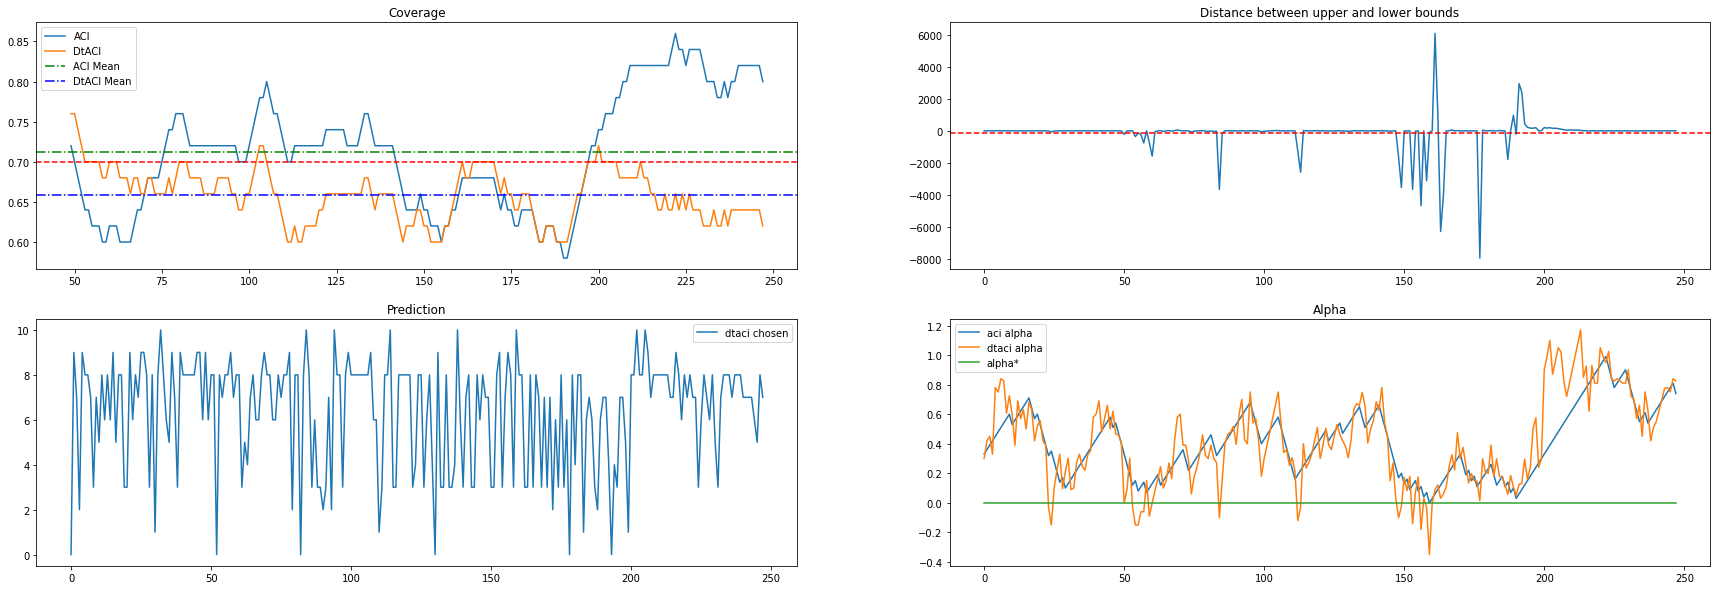

Got ACI
Got DtACI
ACI Coverage: 0.7011948632049134, DtACI Coverage: 0.6975879396984924
ACI variance: 0.005256392515340523, DtACI variance: 0.0012296457160172747


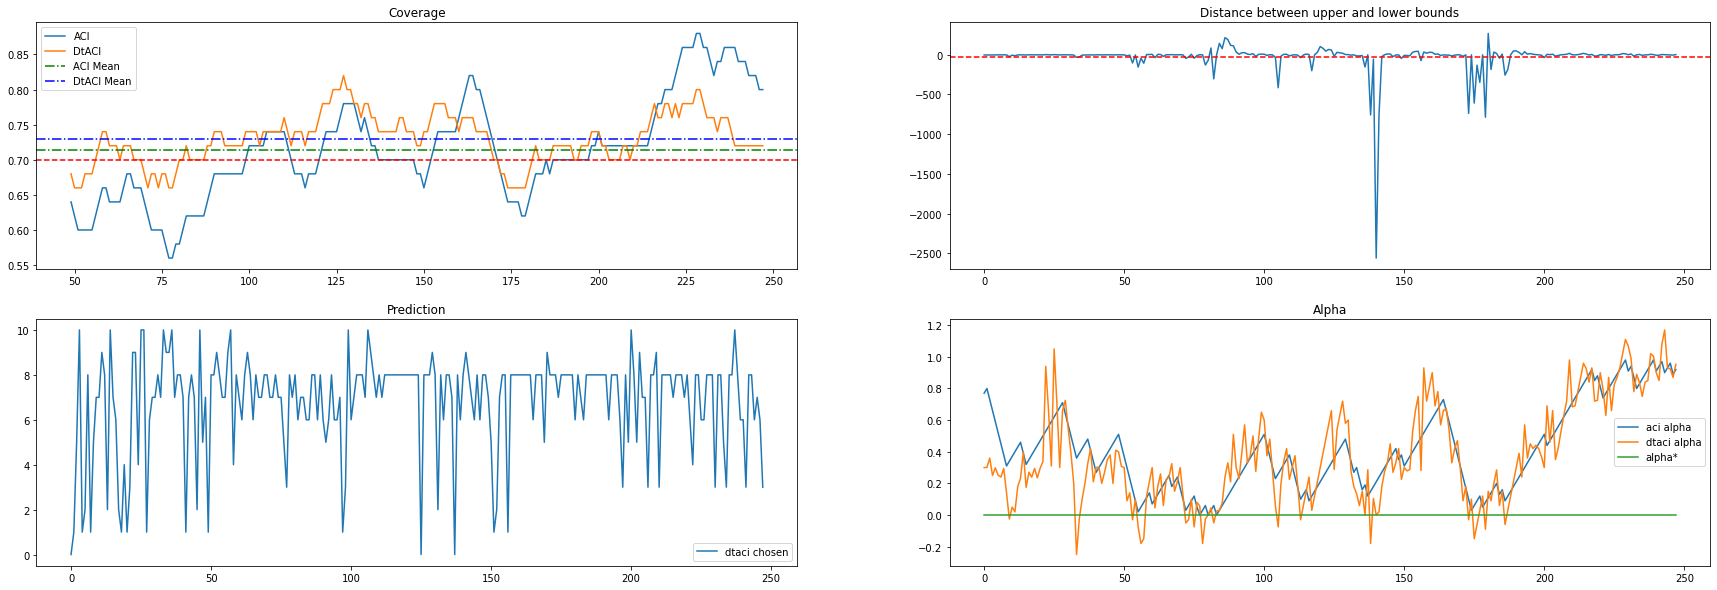

Got ACI
Got DtACI
ACI Coverage: 0.6999682623644538, DtACI Coverage: 0.698053425019836
ACI variance: 0.0047975556172823895, DtACI variance: 0.003600838362667611


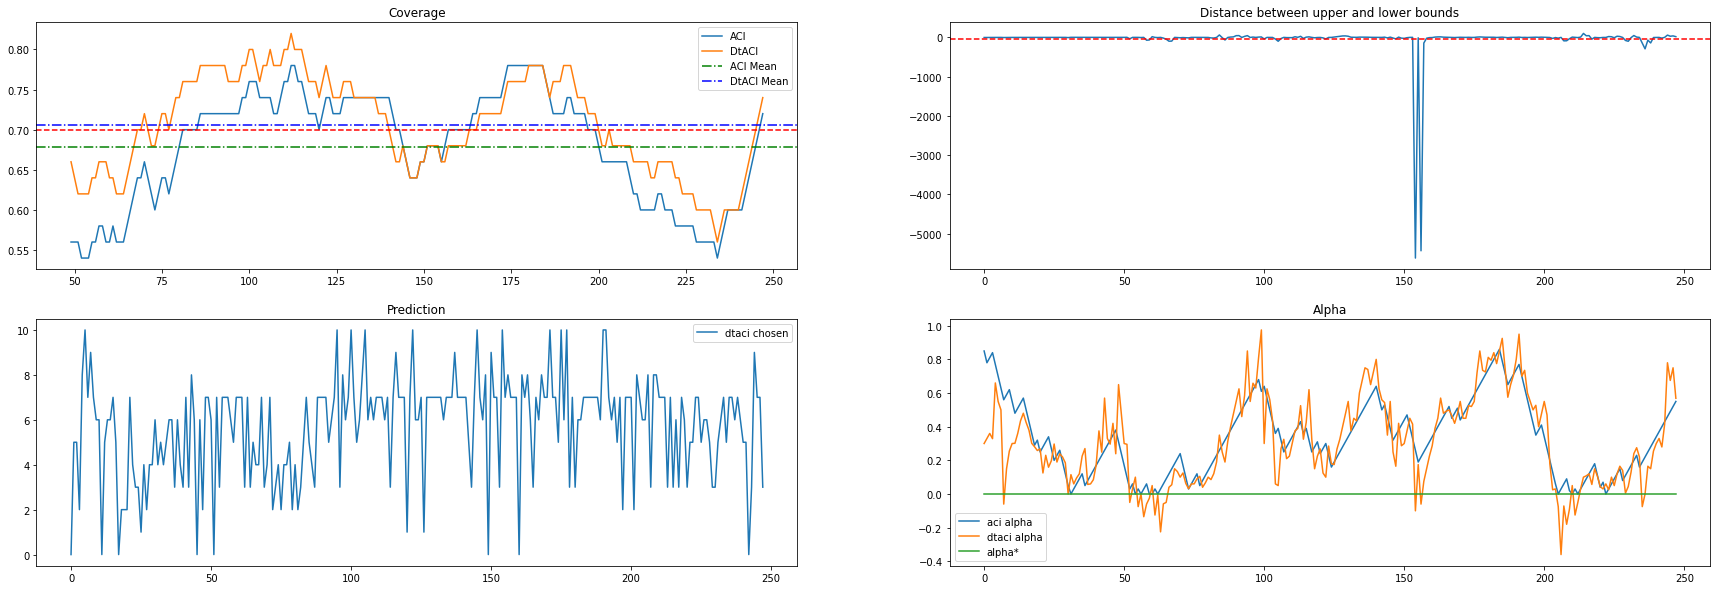

Got ACI
Got DtACI
ACI Coverage: 0.698824120603015, DtACI Coverage: 0.6992713567839196
ACI variance: 0.009621656018787403, DtACI variance: 0.003551970909825512


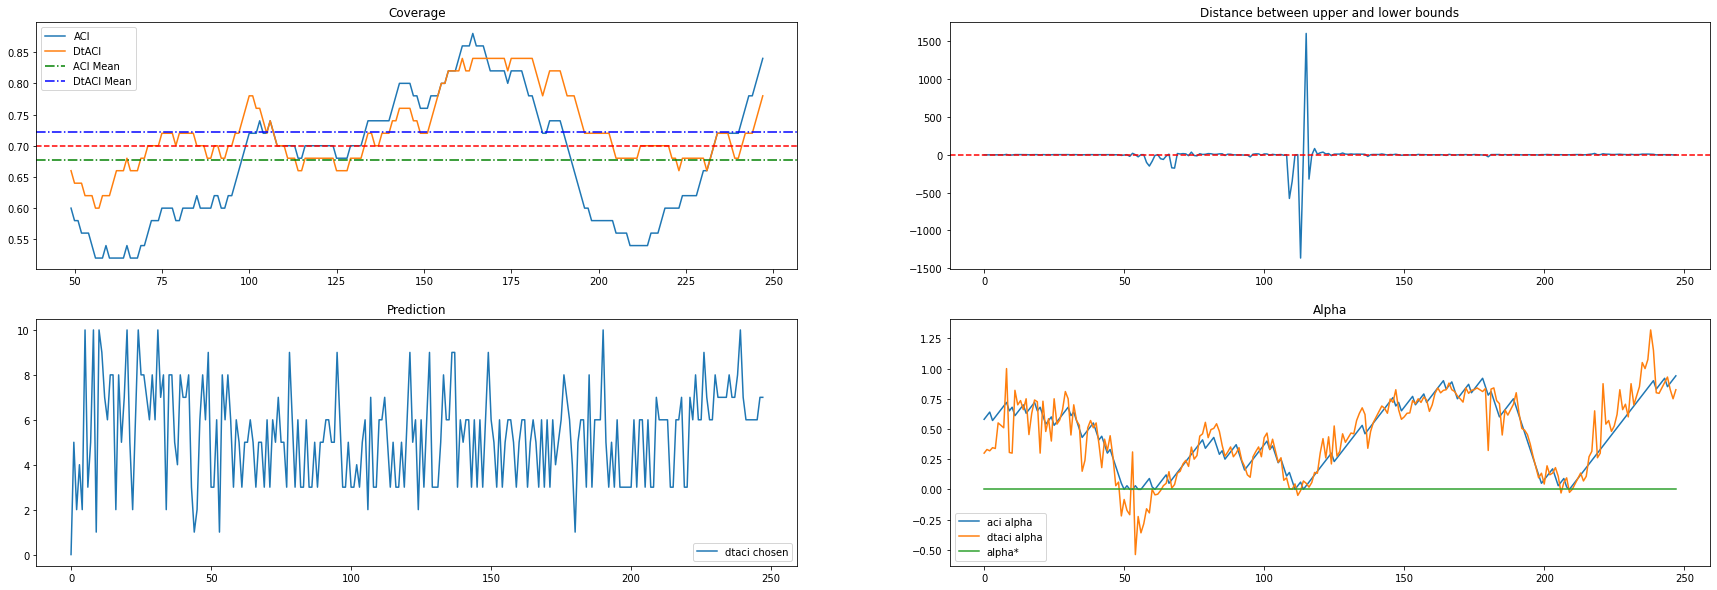

In [42]:
alpha = 0.3

ACI_gen = ACI(alpha, 0.1, train_Output, plots=False)
Dt_ACI_gen = Dt_ACI(alpha, train_Output, plots=False)

aci_average_coverage_multi = []
dtaci_average_coverage_multi = []

for stock in range(len(train_Output)):
    aci_error_list, aci_range, aci_alpha, alpha_star = next(ACI_gen)
    print('Got ACI')
    dtaci_error_list, dtaci_range, dtaci_alpha, chosen = next(Dt_ACI_gen)
    print('Got DtACI')

    aci_distance = np.array([ele[1]-ele[0] for ele in aci_range])
    dtaci_distance = np.array([ele[1]-ele[0] for ele in dtaci_range])

    aci_coverage_t = 1 - pd.Series(aci_error_list).rolling(50).mean()
    dtaci_coverage_t = 1 - pd.Series(dtaci_error_list).rolling(50).mean()

    aci_average_coverage = aci_coverage_t.mean()
    dtaci_average_coverage = dtaci_coverage_t.mean()

    aci_average_coverage_multi.append(aci_average_coverage)
    dtaci_average_coverage_multi.append(dtaci_average_coverage)

    print(f'ACI Coverage: {np.mean(aci_average_coverage_multi)}, DtACI Coverage: {np.mean(dtaci_average_coverage_multi)}')
    print(f'ACI variance: {np.var(aci_coverage_t)}, DtACI variance: {np.var(dtaci_coverage_t)}')

    fig, axs = plt.subplots(2, 2, figsize=(30, 10))
    axs[0][0].plot(aci_coverage_t, label='ACI')
    axs[0][0].plot(dtaci_coverage_t, label='DtACI')
    axs[0][0].axhline(aci_average_coverage, color='g', linestyle='-.', label='ACI Mean')
    axs[0][0].axhline(dtaci_average_coverage, color='b', linestyle='-.', label='DtACI Mean')

    axs[0][0].axhline(1 - alpha, color='r', linestyle='--')
    axs[0][0].legend()
    axs[0][0].set_title('Coverage')

    axs[0][1].plot(aci_distance - dtaci_distance , label='Difference in predictions.')
    axs[0][1].axhline(np.mean(aci_distance - dtaci_distance), color='r', linestyle='--')
    axs[0][1].set_title('Distance between upper and lower bounds')

    axs[1][0].plot(chosen, label='dtaci chosen')
    axs[1][0].set_title('Prediction')
    axs[1][0].legend()

    axs[1][1].plot(aci_alpha,label='aci alpha')
    axs[1][1].plot(dtaci_alpha, label='dtaci alpha')
    axs[1][1].plot(alpha_star, label='alpha*')
    axs[1][1].legend()
    axs[1][1].set_title('Alpha')
    
    plt.show()
    



In [43]:
# The main critique of ACI is that it just corrects for its mistakes. So it will be intresting to see if you just take some random samples of the coverage how close they woudld be to the desired level.
# Would it be easier to just give different sequence lengths as inputs and see the effect of this.

Observed that sometimes. prob due to beng unluck we have that one weight gets over assigned probabilty and then it gets chosen almost every time which can cause a terrible result which throws of the entire average. Am also noticing that the variamce is of dtaci is consittently lower which supports the hypothesis that it is not correctig its mistakes.

Also the fact that there is chanve involved means that sometimes a clearly bad weight is chosen by chance.